In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from cell_weighting import CellReweighter, RakeReweighter
from data import CD_REG_DF, load_crosstab_data

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
CROSSTAB_COLS = ["CD1", "CD2", "CD3", "CD4", "VOTED_2020_TRUMP", "VOTED_2020_BIDEN", "VOTED_2020_DIDNT",
                 "CHILD_LT_18", "EDU_NO_COLL", "EDU_COLL"]
CROSSTAB_COL_GROUPS = [["CD1", "CD2", "CD3", "CD4"], ["VOTED_2020_TRUMP", "VOTED_2020_BIDEN", "VOTED_2020_DIDNT"],
                       ["CHILD_LT_18"], ["EDU_NO_COLL", "EDU_COLL"]]
CONST_COLS = ["CANDIDATE", "LV"]

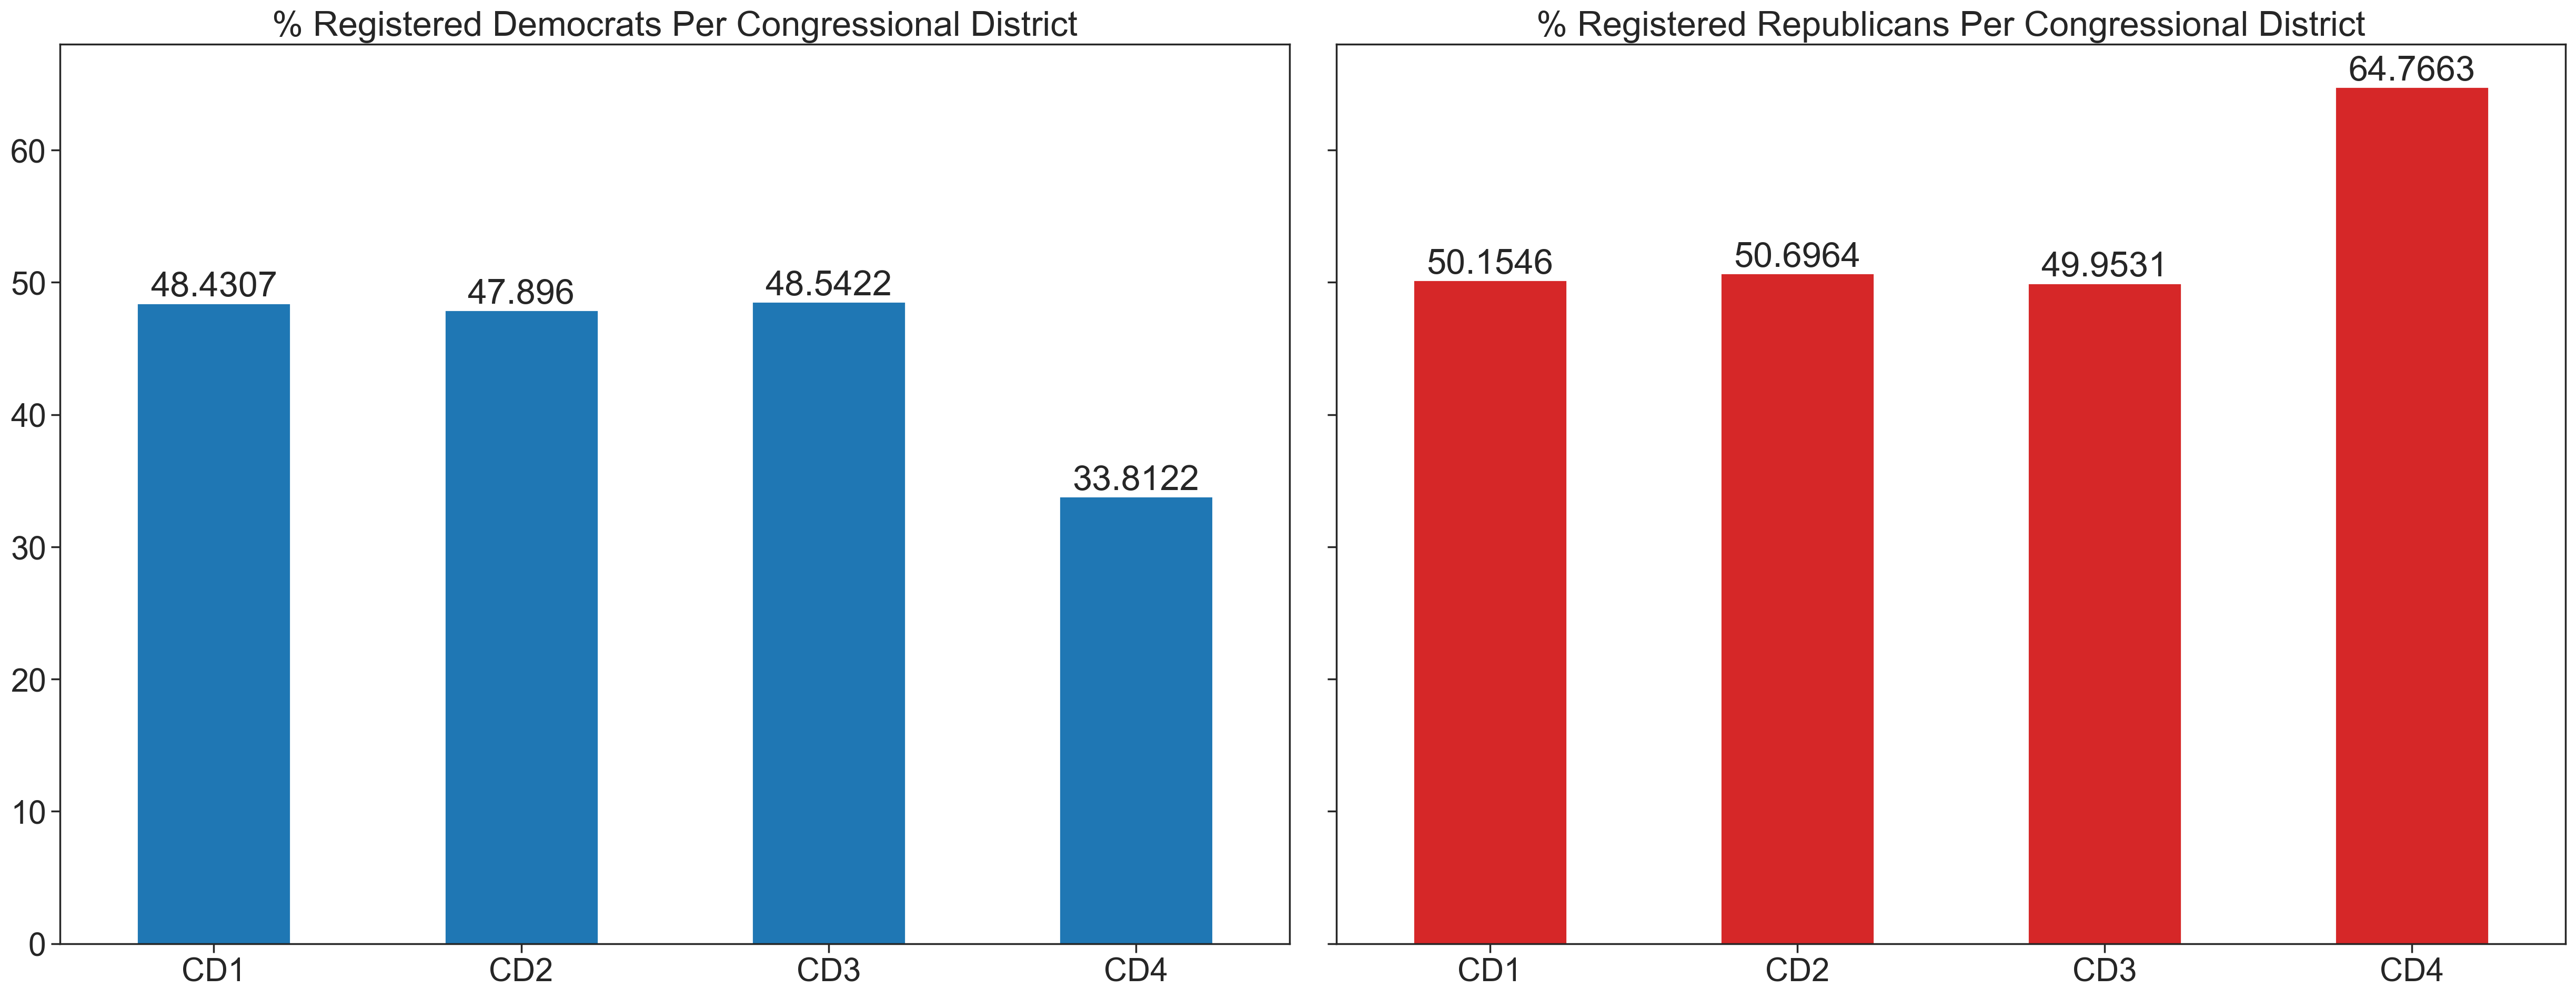

In [5]:
(fig, axs) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(25, 10)

temp = CD_REG_DF.div(CD_REG_DF.sum(axis=0), axis=1) * 100

temp.loc["DEM"].plot(kind="bar", rot=0, color="tab:blue", ax=axs[0])
axs[0].bar_label(axs[0].containers[0])
axs[0].set_title("% Registered Democrats Per Congressional District")

temp.loc["REP"].plot(kind="bar", rot=0, color="tab:red", ax=axs[1])
axs[1].bar_label(axs[1].containers[0])
axs[1].set_title("% Registered Republicans Per Congressional District")

plt.tight_layout()

---

## Load Crosstab

In [6]:
crosstab_df = load_crosstab_data()

In [7]:
crosstab_df

,CANDIDATE,LV,CD1,CD2,CD3,CD4,VOTED_2020_TRUMP,VOTED_2020_BIDEN,VOTED_2020_DIDNT,VOTED_UNK,CHILD_LT_18,CHILD_UNK,EDU_NO_COLL,EDU_COLL,EDU_UNK
0,HARRIS,399.0,113.0,99.0,100.0,87.0,12.0,322.0,48.0,17.0,98.0,301.0,205.0,191.0,3.0
1,TRUMP,372.0,78.0,97.0,91.0,107.0,299.0,13.0,45.0,15.0,114.0,258.0,270.0,97.0,5.0
2,OTHER,78.0,20.0,21.0,18.0,19.0,25.0,10.0,10.0,33.0,21.0,57.0,51.0,24.0,3.0


In [8]:
crosstab_df.set_index("CANDIDATE")["LV"] / crosstab_df["LV"].sum()

CANDIDATE
HARRIS    0.469965
TRUMP     0.438163
OTHER     0.091873
Name: LV, dtype: float64

In [9]:
0.469965 - 0.438163

0.031802

---

## Basic Cell-by-Cell Weighting

### Data Prep

In [11]:
cols = ["CD1", "CD2", "CD3", "CD4"]
ct_df = crosstab_df.set_index("CANDIDATE")[cols].copy()

# cols = ["B1", "B2", "B3"]
# index = ["A1", "A2", "A3", "A4"]

# ct_df = pandas.DataFrame([[20, 40, 40], [50, 140, 310], [100, 50, 50], [30, 100, 70]],
#                          columns=cols, index=index)

ct_df

,CD1,CD2,CD3,CD4
CANDIDATE,,,,
HARRIS,113.0,99.0,100.0,87.0
TRUMP,78.0,97.0,91.0,107.0
OTHER,20.0,21.0,18.0,19.0


In [28]:
# sample_df = pandas.DataFrame([[80, 40, 55], [60, 150, 340], [170, 60, 200], [55, 165, 125]],
#                              index=index, columns=cols)

# just assume even sampling
# and with a response rate of 0.5%, at 808 respondents before weighting is a total sample size of 161,600

sample_df = pandas.DataFrame([[161600 // 12, 161600 // 12, 161600 // 12, 161600 // 12]] * 3,
                             index=ct_df.index, columns=cols)
sample_df

,CD1,CD2,CD3,CD4
CANDIDATE,,,,
HARRIS,13466,13466,13466,13466
TRUMP,13466,13466,13466,13466
OTHER,13466,13466,13466,13466


In [18]:
pop_df = CD_REG_DF.copy()
pop_df.index = ct_df.index

# pop_df = sample_df + 100
pop_df

,CD1,CD2,CD3,CD4
CANDIDATE,,,,
HARRIS,177921,170303,179174,123853
TRUMP,184254,180260,184382,237237
OTHER,5197,5005,5554,5207


In [19]:
sample_df.sum(axis=1) / sample_df.sum(axis=1).sum()

CANDIDATE
HARRIS    0.333333
TRUMP     0.333333
OTHER     0.333333
dtype: float64

In [27]:
pop_df.sum(axis=1) / pop_df.sum(axis=1).sum()

CANDIDATE
HARRIS    0.446568
TRUMP     0.539058
OTHER     0.014374
dtype: float64

### Cell Weighting

In [20]:
cr = CellReweighter(ct_df, sample_df, pop_df, cols)

In [21]:
reweighted_df = cr.reweight()
reweighted_df

Survey crosstab vs. survey sample F = 1.6463126270615192
Survey sample vs. population F = 1.4948441632594336


,CD1,CD2,CD3,CD4
CANDIDATE,,,,
HARRIS,2.120251e+07,2.316465e+07,2.412757e+07,1.917017e+07
TRUMP,3.180980e+07,2.502455e+07,2.728448e+07,2.985639e+07
OTHER,3.499140e+06,3.209397e+06,4.155009e+06,3.690393e+06


In [22]:
reweighted_df.sum(axis=1) / reweighted_df.sum(axis=1).sum()

CANDIDATE
HARRIS    0.405492
TRUMP     0.527189
OTHER     0.067319
dtype: float64

In [29]:
0.405492 - 0.527189

-0.121697

---

## Basic Raking

In [23]:
rr = RakeReweighter(ct_df, sample_df, pop_df, cols)

In [24]:
raked_df = rr.reweight()

2it [00:00, 340.16it/s]
Survey crosstab vs. survey sample F = 1.6469488576113296
0it [00:00, ?it/s]
Survey sample vs. population F = 1.4709489524996266


In [25]:
raked_df

,CD1,CD2,CD3,CD4
CANDIDATE,,,,
HARRIS,2.216999e+07,2.066544e+07,2.299249e+07,2.211114e+07
TRUMP,2.864534e+07,2.670134e+07,2.970806e+07,2.856929e+07
OTHER,3.655638e+06,3.407550e+06,3.791260e+06,3.645934e+06


In [26]:
raked_df.sum(axis=1) / raked_df.sum(axis=1).sum()

CANDIDATE
HARRIS    0.407006
TRUMP     0.525883
OTHER     0.067112
dtype: float64

In [30]:
0.407006 - 0.525883

-0.11887700000000001